## BART for classical ML and uplift modeling

This notebook shows how to use the BART implementation for both a classic ML setting and causal inference. 
References:

[[1] Chipman et al. (2010)](https://arxiv.org/abs/0806.3286)\
[[2] Hill (2011)](https://www.researchgate.net/publication/236588890_Bayesian_Nonparametric_Modeling_for_Causal_Inference)\
[[3] Kapelner and Bleich (2014)](https://arxiv.org/abs/1312.2171)\
[[4] Tan and Roy (2019)](https://arxiv.org/abs/1901.07504)\
[BartPy](https://github.com/JakeColtman/bartpy)

Remarks:
 - Current implementation for uplift modeling only handles binary treatment.
 - Also, only regression and binary classification problems. 
     [Kindo et al. (2014)](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.756.2187&rep=rep1&type=pdf) proposes an extension to multiclass.
 - Parallelization 
     [Pratola et al. (2013)](https://arxiv.org/abs/1309.1906)
 - Include support for confidence intervals on predictions
 - Add support for MCMC statistics

## 1 Classic ML setting

In [1]:
# Only if running this notebook inside the repository tree
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### 1.1 Regression problem 

In [2]:
import numpy as np
import pandas as pd

from causalml.inference.tree import BART
from causalml.metrics import get_cumgain
from causalml.dataset import synthetic_data
from causalml.metrics import plot_gain

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression, make_classification
from sklearn.metrics import mean_squared_error, classification_report

SEED = 42
FIGSIZE = (15, 5)

np.random.seed(SEED)
plt.rcParams['figure.figsize'] = FIGSIZE

Failed to import duecredit due to No module named 'duecredit'


In [3]:
X, y = make_regression(n_samples=1000, n_features=1, n_informative=1, random_state=SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=pd.qcut(y, 10), test_size=0.25, random_state=SEED)

bart = BART(m=35)
bart.fit(X=X_train, y=y_train, max_iter=50)

100%|███████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s]


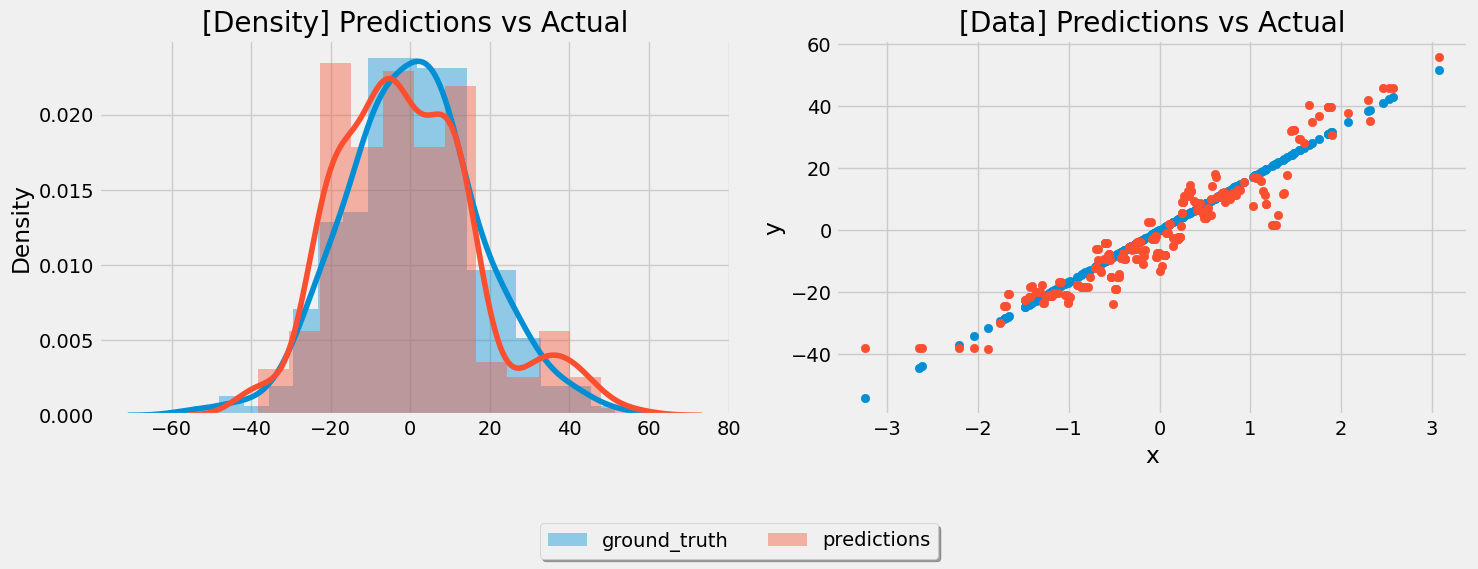

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2)

y_pred = bart.predict(X_test, rescale=True)
sns.distplot(y_test, label='ground_truth', ax=ax1)
sns.distplot(y_pred.flatten(), label='predictions', ax=ax1)
ax1.set_title('[Density] Predictions vs Actual')

ax2.scatter(X_test, y_test, label='_nolegend_')
ax2.scatter(X_test, y_pred, label='_nolegend_')
ax2.set_title('[Data] Predictions vs Actual')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
f.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.tight_layout()
plt.show();

### 1.2 Binary classification problem

In [5]:
X, y = make_classification(n_samples=1000, 
                           n_features=2, 
                           n_informative=2, 
                           n_redundant=0, 
                           n_classes=2, 
                           random_state=SEED) 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=SEED)

bart = BART(m=35)
bart.fit(X=X_train, y=y_train, max_iter=50)

print(classification_report(y_test, np.rint(bart.predict(X_test))))

100%|███████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.79it/s]

              precision    recall  f1-score   support

           0       0.91      0.74      0.82       125
           1       0.78      0.93      0.85       125

    accuracy                           0.84       250
   macro avg       0.85      0.84      0.83       250
weighted avg       0.85      0.84      0.83       250



## 2 Uplift Modeling

It's possible to use this implementation of BART for uplift modeling too. The only requirement is to pass an argument to the `treatment` parameter of the `fit` method. Then, the model will automatically switch from a classical ML setting to uplift modeling.

100%|███████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.73it/s]


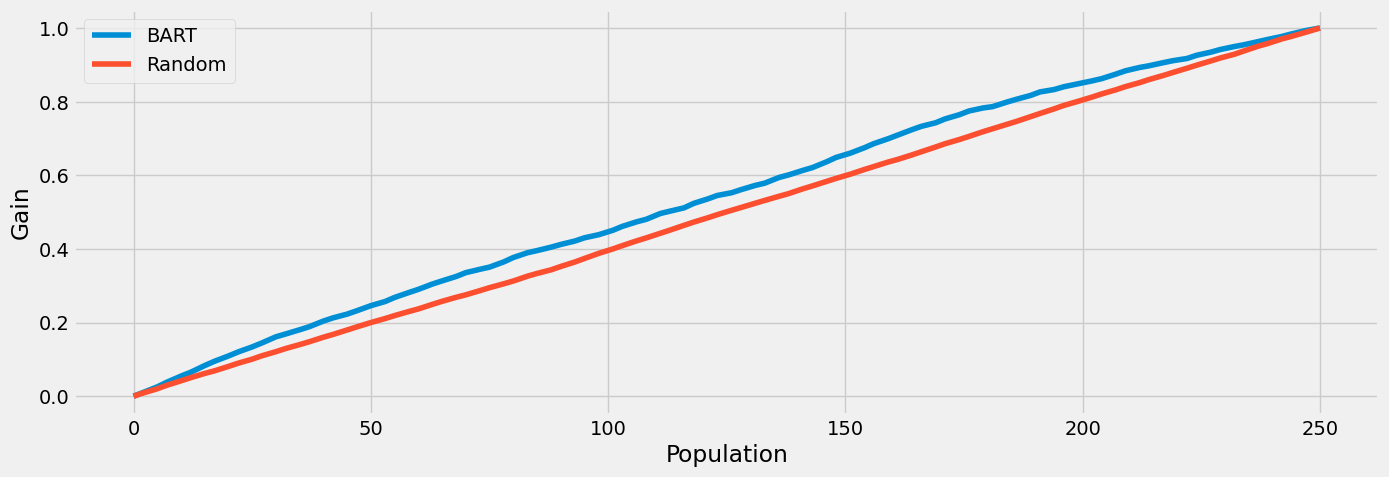

In [5]:
y, X, w, tau, b, e = synthetic_data()
X_train, X_test, y_train, y_test = train_test_split(np.concatenate([X, 
                                                                    w.reshape(-1, 1), 
                                                                    tau.reshape(-1, 1)], 
                                                                   axis=1), 
                                                    y, 
                                                    stratify=pd.qcut(y, 10), 
                                                    test_size=0.25, 
                                                    random_state=SEED)
tau_train = X_train[:, -1].reshape(-1, 1)
w_train = X_train[:, -2].reshape(-1, 1)
X_train = X_train[:, :-2]
tau_test = X_test[:, -1].reshape(-1, 1)
w_test = X_test[:, -2].reshape(-1, 1)
X_test = X_test[:, :-2]

bart = BART(m=35)
bart.fit(X=X_train, treatment=w_train, y=y_train, max_iter=50)

y_pred = bart.predict(X_test, rescale=True)
df_preds = pd.DataFrame({'BART':y_pred.flatten(), 
                         'tau':tau_test.flatten(), 
                         'w':w_test.flatten(), 
                         'y': y_test.flatten()})

plot_gain(df_preds, figsize=FIGSIZE, normalize=True)

In [7]:
df_preds.head()

,BART,tau,w,y
0,0.658087,0.717919,1.0,2.630888
1,1.113596,0.576265,1.0,1.371893
2,1.261420,0.652550,1.0,2.934398
3,0.281276,0.904366,1.0,2.169660
4,-0.653968,0.308311,0.0,0.191269


In [8]:
df_res = bart.predict(X_test, rescale=True, full_output=True)
df_res

,control,treatment_1,recommended_treatment,delta_1
0,2.469308,3.127394,1,0.658087
1,1.639152,2.752749,1,1.113596
2,1.901441,3.162860,1,1.261420
3,1.588156,1.869432,1,0.281276
4,0.721001,0.067033,0,-0.653968
...,...,...,...,...
245,0.689043,2.181622,1,1.492579
246,1.455704,2.615783,1,1.160079
247,1.435684,2.461155,1,1.025471
248,1.413157,3.113892,1,1.700735


### Optimization oportunities

In [9]:
import cProfile, pstats, io

def profile(fnc):
    
    """Source: https://gist.github.com/jmeisele/703f7ebd9280baf757bc7c228a3a9f9c
        A decorator that uses cProfile to profile a function
    """
    
    def inner(*args, **kwargs):
        
        pr = cProfile.Profile()
        pr.enable()
        retval = fnc(*args, **kwargs)
        pr.disable()
        s = io.StringIO()
        sortby = 'cumulative'
        ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
        return retval

    return inner

By analyzing the optimization opportunities, both `predict` and `compute_residual` BART's methods comes first with respect to processing time spent. Both steps have a similar logic, and are proposed to be parallelized according to [Pratola et al. (2013)](https://arxiv.org/abs/1309.1906).

In [10]:
@profile
def run_bart_for_classical_ml():
    X, y = make_regression(n_samples=1000, n_features=1, n_informative=1, random_state=SEED)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=pd.qcut(y, 10), test_size=0.25, random_state=SEED)

    bart = BART(m=35)
    bart.fit(X=X_train, y=y_train, max_iter=50)
    
run_bart_for_classical_ml()

100%|███████████████████████████████████████████████████████████████| 50/50 [00:47<00:00,  1.06it/s]

         214248992 function calls (213393010 primitive calls) in 47.126 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   47.126   47.126 /var/folders/bd/l9rxhc417tx5blpgx4wfbd700000gn/T/ipykernel_38801/1086717040.py:1(run_bart_for_classical_ml)
        1    0.008    0.008   47.111   47.111 /Users/caio.guirado/Desktop/causalml/causalml/inference/tree/bart.py:427(fit)
    61250   23.119    0.000   45.339    0.001 /Users/caio.guirado/Desktop/causalml/causalml/inference/tree/bart.py:77(predict)
     1750    0.004    0.000   44.306    0.025 /Users/caio.guirado/Desktop/causalml/causalml/inference/tree/bart.py:372(compute_residual)
     1750    0.264    0.000   44.302    0.025 /Users/caio.guirado/Desktop/causalml/causalml/inference/tree/bart.py:363(get_all_other_trees_predictions)
116648792   18.188    0.000   18.188    0.000 /Users/caio.guirado/Desktop/causalml/causalml/inference/tree/bart.py:58(app